# Introdução

## **Contexto**

A Insurance All é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.

Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha.

## **Desafio**

Nesse contexto, você foi contratado como um consultor de Ciência de Dados para construir um modelo que prediz se o cliente estaria ou não interessado no seguro de automóvel. 

Com a sua solução, o time de vendas espera conseguir priorizar as pessoas com maior interesse no novo produto e assim, otimizar a campanha realizando apenas contatos aos clientes mais propensos a realizar a compra.

Como resultado da sua consultoria, você precisará entregar um relatório contendo algumas análises e respostas às seguintes perguntas:

Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.
Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?
E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?
Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

# 0.0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek

from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, make_scorer, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve

from sklearn.metrics import confusion_matrix

import pickle

In [2]:
warnings.filterwarnings('ignore')

## 0.1. Funções Auxiliares

In [3]:
def score_ml(nome_modelo, model):
    num_fold = 5
    kfold = StratifiedKFold( n_splits=num_fold, shuffle=True, random_state=0 )
    
    balanced_acc_list = []
    kappa_acc_list = []
    
    i = 1
    for train_ix, val_ix in kfold.split( X_resampled, y_resampled ):
        print( f"Fold Number: { i }/{ num_fold }" )
        
        # get fold
        x_train_fold = X_resampled.iloc[train_ix]
        y_train_fold = y_resampled.iloc[train_ix]
        
        x_val_fold = X_resampled.iloc[val_ix]
        y_val_fold = y_resampled.iloc[val_ix]
        
        # train model
        model.fit( x_train_fold, y_train_fold )
        
        # predict labels
        y_pred = model.predict(x_val_fold)
        
        # metrics
        ## Balanced Accuracy
        balanced_acc_model = balanced_accuracy_score( y_val_fold, y_pred )
        balanced_acc_list.append( balanced_acc_model )
        
        ## Kappa Metrics
        kappa_acc_model = cohen_kappa_score( y_val_fold, y_pred )
        kappa_acc_list.append( kappa_acc_model )
        
        i += 1
    
    print( f'\nAvg Balanced Accuracy: {np.mean( balanced_acc_list ):.4} +/- {np.std( balanced_acc_list ):.4}' )
    print( f'Avg Kappa: {np.mean( kappa_acc_list ):.4} +/- {np.std( kappa_acc_list ):.4}' )

In [4]:
def metric_score(model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='0')
    recall = recall_score(y_test, y_pred, pos_label='0')
    f1 = f1_score(y_test, y_pred, pos_label='0')
    balanced = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    print(f'Accuracy = {accuracy:.3}')
    print(f'Precision = {precision:.3}')
    print(f'Recall = {recall:.3}')
    print(f'F1 score = {f1:.3}')
    print(f'Balanced Accuracy = {balanced:.3}')
    print(f'Kappa Score = {kappa:.3}')
    conf_matrix(y_test, y_pred)

In [5]:
def conf_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    cm_data = pd.DataFrame(cm, columns = ['Positive', 'Negative'], index=['Positive', 'Negative'])
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 24}).set_title('Confusion Matrix')

    return plt.show()

# 1.0. Dados

## 1.1. Carregando os Dados

In [6]:
train = pd.read_csv('../data/train.csv', index_col='id', dtype={'Gender': 'category',
                                                        'Region_Code': 'int16',
                                                        'Vehicle_Age': 'category',
                                                        'Vehicle_Damage': 'category',
                                                        'Response': 'category'})
test = pd.read_csv('../data/test.csv', index_col='id', dtype={'Gender': 'category',
                                                        'Region_Code': 'int16',
                                                        'Vehicle_Age': 'category',
                                                        'Vehicle_Damage': 'category',
                                                        'Response': 'category'})

## 1.2. Verificação do Dataset

In [7]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41,1,< 1 Year,No,27496.0,152.0,39,0


In [8]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
381110,Male,25,1,11,1,< 1 Year,No,35786.0,152.0,53
381111,Male,40,1,28,0,1-2 Year,Yes,33762.0,7.0,111
381112,Male,47,1,28,0,1-2 Year,Yes,40050.0,124.0,199
381113,Male,24,1,27,1,< 1 Year,Yes,37356.0,152.0,187
381114,Male,27,1,28,1,< 1 Year,No,59097.0,152.0,297


## 1.3. Dimensão dos Dados

In [9]:
print(f'Dimensão dos dados de treino = {train.shape}')
print(f'Dimensão dos dados de test = {test.shape}')

Dimensão dos dados de treino = (381109, 11)
Dimensão dos dados de test = (127037, 10)


## 1.4. Tipo de Dados

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                381109 non-null  category
 1   Age                   381109 non-null  int64   
 2   Driving_License       381109 non-null  int64   
 3   Region_Code           381109 non-null  int16   
 4   Previously_Insured    381109 non-null  int64   
 5   Vehicle_Age           381109 non-null  category
 6   Vehicle_Damage        381109 non-null  category
 7   Annual_Premium        381109 non-null  float64 
 8   Policy_Sales_Channel  381109 non-null  float64 
 9   Vintage               381109 non-null  int64   
 10  Response              381109 non-null  category
dtypes: category(4), float64(2), int16(1), int64(4)
memory usage: 22.5 MB


## 1.5. Dicionário de Dados

### Dicionário de Features

- **Id:** identificador único do cliente.
- **Gender:** gênero do cliente.
- **Age:** idade do cliente.
- **Driving License:** 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
- **Region Code:** código da região do cliente.
- **Previously Insured:** 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
- **Vehicle Age:** idade do veículo.
- **Vehicle Damage:** 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
- **Anual Premium:** quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
- **Policy sales channel:** código anônimo para o canal de contato com o cliente.
- **Vintage:** número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
- **Response:** 0, o cliente não tem interesse e 1, o cliente tem interesse.

# 2.0. Análise Descritiva

## 2.1. Agrupamento dos Dados

In [11]:
df_concat = train.append(test)
df_concat

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
508142,Female,26,1,37,1,< 1 Year,No,30867.0,152.0,56,NaN
508143,Female,38,1,28,0,1-2 Year,Yes,28700.0,122.0,165,NaN
508144,Male,21,1,46,1,< 1 Year,No,29802.0,152.0,74,NaN


In [12]:
df_concat[df_concat['Gender'] == 'Male']

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11,1,< 1 Year,No,28619.0,152.0,203,0
7,Male,23,1,11,0,< 1 Year,Yes,23367.0,152.0,249,0
...,...,...,...,...,...,...,...,...,...,...,...
508139,Male,64,1,28,0,1-2 Year,No,39038.0,26.0,62,NaN
508141,Male,21,1,8,1,< 1 Year,No,35767.0,152.0,195,NaN
508144,Male,21,1,46,1,< 1 Year,No,29802.0,152.0,74,NaN


## 2.2 Medidas Descritivas

In [13]:
round(df_concat.describe(),2).iloc[1:, :]

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
mean,38.81,1.00,26.41,0.46,30554.45,111.98,154.34
std,15.50,0.05,13.22,0.50,17146.57,54.25,83.67
min,20.00,0.00,0.00,0.00,2630.00,1.00,10.00
25%,25.00,1.00,15.00,0.00,24381.00,26.00,82.00
50%,36.00,1.00,28.00,0.00,31661.00,133.00,154.00
75%,49.00,1.00,35.00,1.00,39403.75,152.00,227.00
max,85.00,1.00,52.00,1.00,540165.00,163.00,299.00


## 2.3. Análise das features

### 2.3.1. Gender

Homens      274325
Mulheres    233821
Name: Gender, dtype: int64


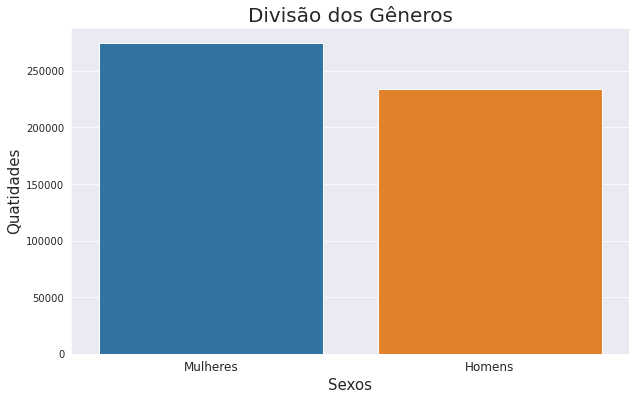

In [14]:
%matplotlib inline
qnt_por_genero = df_concat['Gender'].value_counts()
qnt_por_genero.index = ['Homens', 'Mulheres']
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
print(qnt_por_genero)
plt.title('Divisão dos Gêneros', fontsize=20)
ax = sns.barplot(x=qnt_por_genero.index, y=qnt_por_genero.values)
ax.set_xlabel('Sexos', fontsize=15)
ax.set_ylabel('Quatidades', fontsize=15)
ax.set_xticklabels(['Mulheres', 'Homens'], fontsize=12)
plt.savefig('../images/gender.png')

### 2.3.2. Age

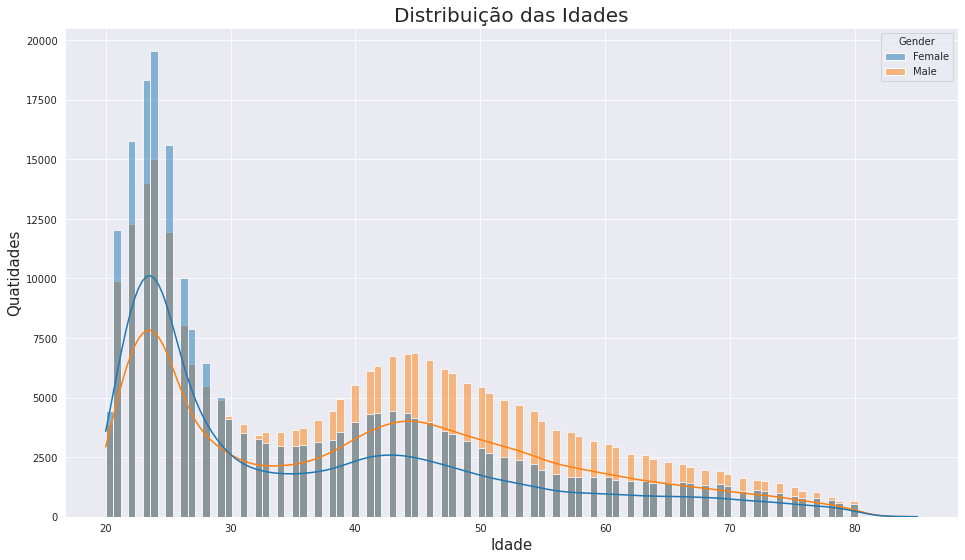

In [15]:
%matplotlib inline
plt.figure(figsize=(16,9))
plt.title('Distribuição das Idades', fontsize=20)
ax = sns.histplot(data=df_concat, x="Age", kde=True, hue="Gender")
ax.set_xlabel('Idade', fontsize=15)
ax.set_ylabel('Quatidades', fontsize=15)
plt.savefig('../images/age.png')

### 2.3.3. Driving_License

In [16]:
qnt_motoristas = df_concat['Driving_License'].value_counts()
qnt_motoristas

1    507097
0      1049
Name: Driving_License, dtype: int64

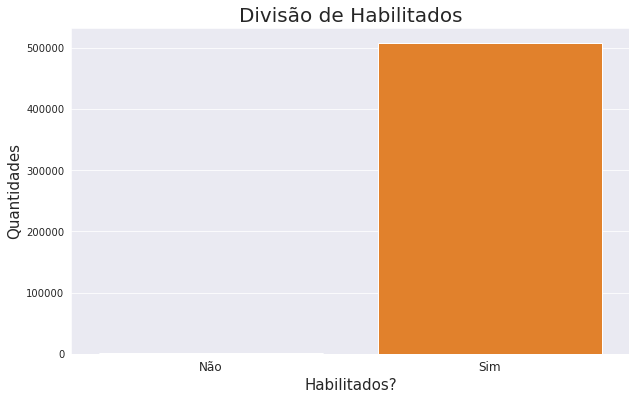

In [17]:
%matplotlib inline
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.title('Divisão de Habilitados', fontsize=20)
ax = sns.barplot(x=qnt_motoristas.index, y=qnt_motoristas.values)
ax.set_xlabel('Habilitados?', fontsize=15)
ax.set_ylabel('Quantidades', fontsize=15)
ax.set_xticklabels(['Não', 'Sim'], fontsize=12)
plt.savefig('../images/driving_license.png')

**Esta feature por ser uma classe bem desbalanceada, é forte candidata a ser retirada do modelo. Menos de 0.5% do total de assegurados pela Insurance All não possui carteira de habilitação**

### 2.3.4. Region_Code

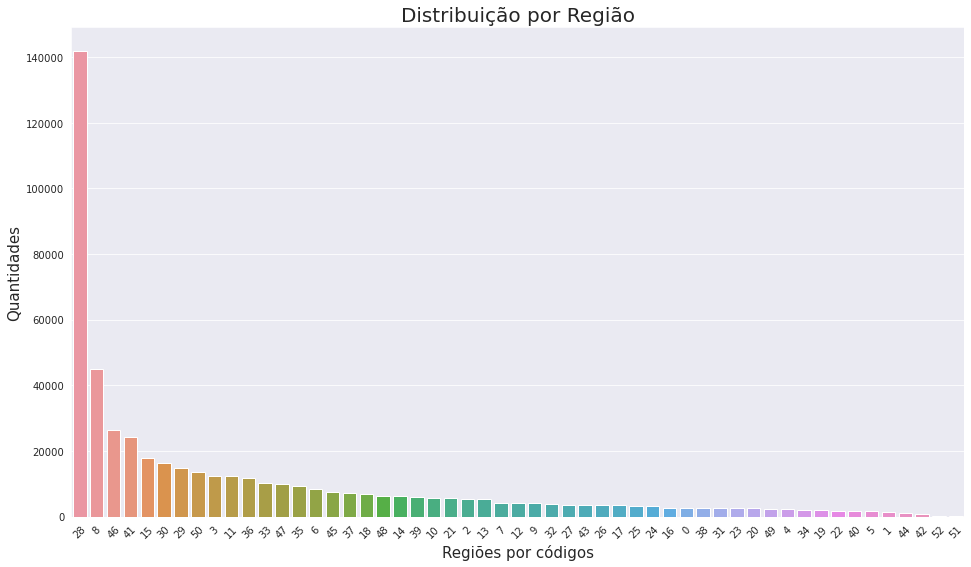

In [18]:
%matplotlib inline
qnt_por_regiao = df_concat['Region_Code'].value_counts()
qnt_por_regiao.sort_values(ascending=False)
sns.set_style('darkgrid')
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)
plt.title('Distribuição por Região', fontsize=20)
ax = sns.barplot(x=qnt_por_regiao.index, y=qnt_por_regiao.values, order=qnt_por_regiao.index)
ax.set_xlabel('Regiões por códigos', fontsize=15)
ax.set_ylabel('Quantidades', fontsize=15)
plt.savefig('../images/region_code.png')

### 2.3.5. Previously_insured

0    275076
1    233070
Name: Previously_Insured, dtype: int64


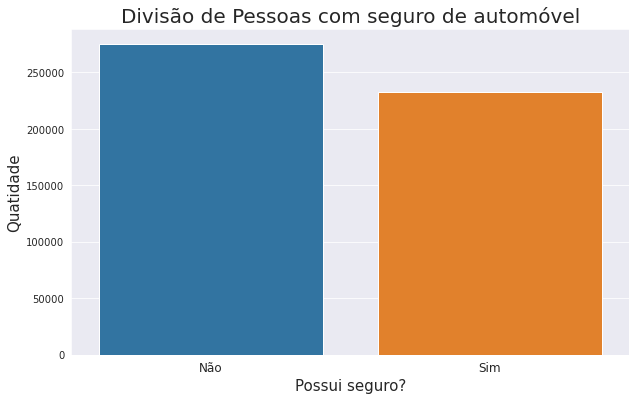

In [19]:
%matplotlib inline
qnt_seguro_automovel = df_concat['Previously_Insured'].value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
print(qnt_seguro_automovel)
plt.title('Divisão de Pessoas com seguro de automóvel', fontsize=20)
ax = sns.barplot(x=qnt_seguro_automovel.index, y=qnt_seguro_automovel.values)
ax.set_xlabel('Possui seguro?', fontsize=15)
ax.set_ylabel('Quatidade', fontsize=15)
ax.set_xticklabels(['Não', 'Sim'], fontsize=12)
plt.savefig('../images/previously_insured.png')

### 2.3.6. Vehicle_Age

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64


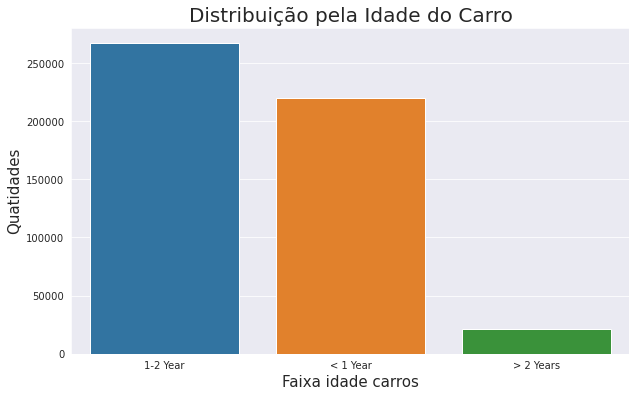

In [20]:
%matplotlib inline
qnt_idade_veiculo = df_concat['Vehicle_Age'].value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
print(qnt_idade_veiculo)
plt.title('Distribuição pela Idade do Carro', fontsize=20)
ax = sns.barplot(x=qnt_idade_veiculo.index, y=qnt_idade_veiculo.values)
ax.set_xlabel('Faixa idade carros', fontsize=15)
ax.set_ylabel('Quatidades', fontsize=15)
plt.savefig('../images/vehicle_age.png')

### 2.3.7. Vehicle_Damage

Yes    256248
No     251898
Name: Vehicle_Damage, dtype: int64


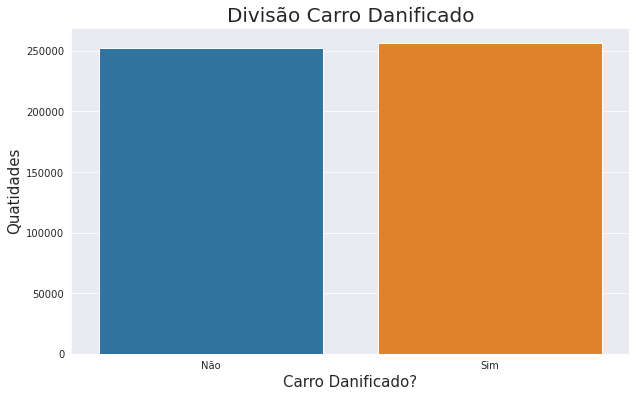

In [21]:
%matplotlib inline
qnt_dano_veiculo = df_concat['Vehicle_Damage'].value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
print(qnt_dano_veiculo)
plt.title('Divisão Carro Danificado', fontsize=20)
ax = sns.barplot(x=qnt_dano_veiculo.index, y=qnt_dano_veiculo.values)
ax.set_xlabel('Carro Danificado?', fontsize=15)
ax.set_ylabel('Quatidades', fontsize=15)
ax.set_xticklabels(labels=['Não', 'Sim'])
plt.savefig('../images/vehicle_damage.png')

### 2.3.8. Annual_Premium

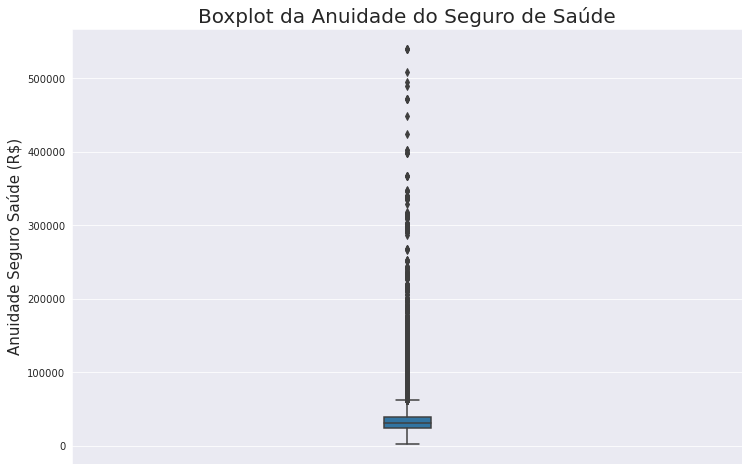

In [22]:
%matplotlib inline
plt.figure(figsize=(12,8))
plt.title('Boxplot da Anuidade do Seguro de Saúde', fontsize=20)
ax = sns.boxplot(data=df_concat, y="Annual_Premium", width=0.07)
ax.set_ylabel('Anuidade Seguro Saúde (R$)', fontsize=15)
plt.savefig('../images/annual_premium.png')

Há uma grande assimetria na distribuição da anuidade do seguro de saúde. Na seção de Preparação dos Dados, corrigiremos esta anomalia.

### 2.3.9. Policy_Sales_Channel

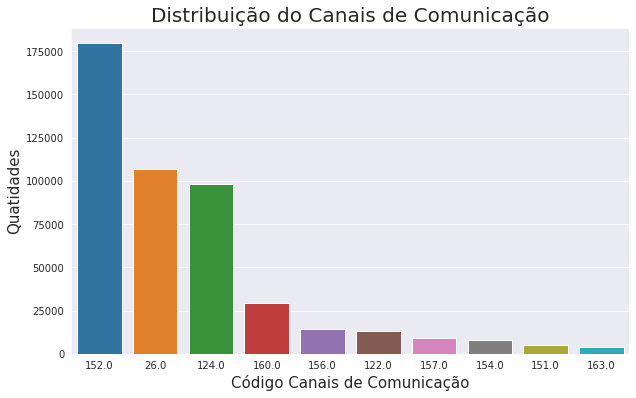

In [23]:
%matplotlib inline
qnt_por_canal_comunicacao = df_concat['Policy_Sales_Channel'].value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
plt.title('Distribuição do Canais de Comunicação', fontsize=20)
ax = sns.barplot(x=qnt_por_canal_comunicacao.index[:10],
                 y=qnt_por_canal_comunicacao.values[:10],
                 order=qnt_por_canal_comunicacao.index[:10])
ax.set_xlabel('Código Canais de Comunicação', fontsize=15)
ax.set_ylabel('Quatidades', fontsize=15)
plt.savefig('../images/policy_sales_channel.png')

### 2.3.10. Response

0    334399
1     46710
Name: Response, dtype: int64


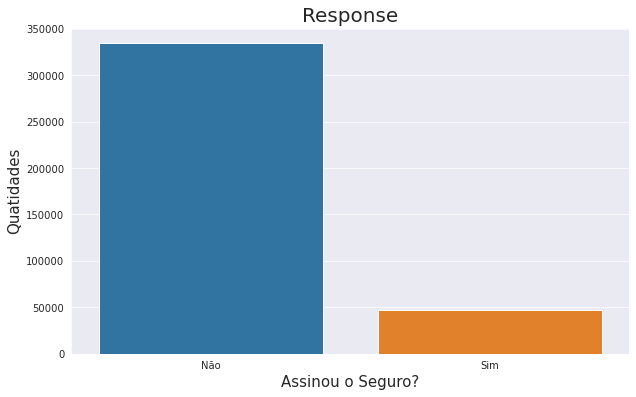

In [24]:
%matplotlib inline
qnt_resposta = df_concat['Response'].value_counts( normalize=False)
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
print(qnt_resposta)
plt.title('Response', fontsize=20)
ax = sns.barplot(x=qnt_resposta.index, y=qnt_resposta.values)
ax.set_xlabel('Assinou o Seguro?', fontsize=15)
ax.set_ylabel('Quatidades', fontsize=15)
ax.set_xticklabels(labels=['Não', 'Sim'])
plt.savefig('../images/response.png')

Podemos notar através do gráfico acima que a classe **Response está DESBALANCEADA**. Trataremos esta anomalia na seção de Preparação dos Dados.

# 3.0.  Análise Multivariada

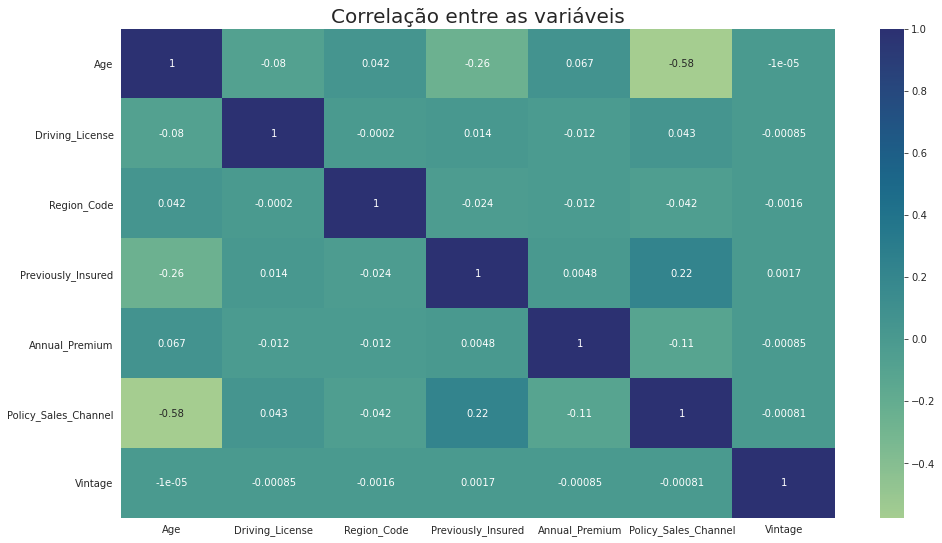

In [25]:
# Correlação pelo método de Pearson
correlacao = df_concat.corr(method='pearson')

plt.figure(figsize=(16,9))
plt.title('Correlação entre as variáveis', fontsize=20)
sns.heatmap(correlacao, annot=True, cmap='crest')
plt.savefig('../images/correlacao_variaveis.png')

# 4.0. Preparação dos Dados

## 4.1. - Transformações Básicas

In [26]:
df_concat['Gender'] = df_concat['Gender'].map({'Male': 0, 'Female': 1}).astype('int32')
df_concat['Vehicle_Damage'] = df_concat['Vehicle_Damage'].map({'No': 0, 'Yes': 1}).astype('int32')

In [27]:
# Excluir a feature 'Driving_Licence do DataFrame'
df_concat.drop(labels='Driving_License', axis=1, inplace=True)

In [28]:
# Aplicando a técnica de One Hot Code na feature 'Vehicle_Age'
df_concat = pd.get_dummies(data=df_concat, columns=['Vehicle_Age'])

In [29]:
# Renomeando as colunas do DataFrame
df_concat.columns = ['Gender', 'Age', 'Region_Code', 'Previously_Insured',
                    'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
                    'Response', 'Vehicle_Age_1-2 Year', 'Vehicle_Age_less 1 Year', 'Vehicle_Age_greater 2 Years']


In [30]:
df_concat['Vehicle_Age_1-2 Year'] = df_concat['Vehicle_Age_1-2 Year'].astype('int32')
df_concat['Vehicle_Age_less 1 Year'] = df_concat['Vehicle_Age_less 1 Year'].astype('int32')
df_concat['Vehicle_Age_greater 2 Years'] = df_concat['Vehicle_Age_greater 2 Years'].astype('int32')

In [31]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508146 entries, 1 to 508146
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Gender                       508146 non-null  int32  
 1   Age                          508146 non-null  int64  
 2   Region_Code                  508146 non-null  int16  
 3   Previously_Insured           508146 non-null  int64  
 4   Vehicle_Damage               508146 non-null  int32  
 5   Annual_Premium               508146 non-null  float64
 6   Policy_Sales_Channel         508146 non-null  float64
 7   Vintage                      508146 non-null  int64  
 8   Response                     381109 non-null  object 
 9   Vehicle_Age_1-2 Year         508146 non-null  int32  
 10  Vehicle_Age_less 1 Year      508146 non-null  int32  
 11  Vehicle_Age_greater 2 Years  508146 non-null  int32  
dtypes: float64(2), int16(1), int32(5), int64(3), object(1)
mem

# 5.0. - Salvando dados

In [32]:
test_df = df_concat[df_concat['Response'].isna()]
test_df = test_df.drop(columns='Response', axis = 1)
test_df.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_1-2 Year,Vehicle_Age_less 1 Year,Vehicle_Age_greater 2 Years
id,,,,,,,,,,,
381110,0,25,11,1,0,35786.0,152.0,53,0,1,0
381111,0,40,28,0,1,33762.0,7.0,111,1,0,0
381112,0,47,28,0,1,40050.0,124.0,199,1,0,0
381113,0,24,27,1,1,37356.0,152.0,187,0,1,0
381114,0,27,28,1,0,59097.0,152.0,297,0,1,0


In [33]:
train_df = df_concat[df_concat['Response'].notna()]
train_df.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1-2 Year,Vehicle_Age_less 1 Year,Vehicle_Age_greater 2 Years
id,,,,,,,,,,,,
1,0,44,28,0,1,40454.0,26.0,217,1,0,0,1
2,0,76,3,0,0,33536.0,26.0,183,0,1,0,0
3,0,47,28,0,1,38294.0,26.0,27,1,0,0,1
4,0,21,11,1,0,28619.0,152.0,203,0,0,1,0
5,1,29,41,1,0,27496.0,152.0,39,0,0,1,0


In [34]:
train_df.to_csv('../data/preprocessed_train_data.csv', index_label='id')

In [35]:
test_df.to_csv('../data/preprocessed_test_data.csv', index_label='id')

# 4.3. - Transformação de Features

In [36]:
X = train_df.drop(columns='Response', axis = 1)
y = train_df['Response']

### Divisão dos Datasets

In [37]:
print(X.shape)
print(y.shape)

(381109, 11)
(381109,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print( f'Shape do X_train = {X_train.shape}' )
print( f'Shape do y_train = {y_train.shape}' )
print( f'Shape do X_test = {X_test.shape}' )
print( f'Shape do y_test = {y_test.shape}' )

Shape do X_train = (304887, 11)
Shape do y_train = (304887,)
Shape do X_test = (76222, 11)
Shape do y_test = (76222,)


# Oversampling Response Feature

In [39]:
# sampler = SMOTETomek(sampling_strategy='minority' ,random_state=42)
# X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
# print(y_resampled.value_counts() )

In [40]:
undersampling = NearMiss(sampling_strategy=0.6)
X_resampled, y_resampled = undersampling.fit_sample(X_train, y_train)

In [41]:
print(y_resampled.value_counts(normalize=True))

0    0.625
1    0.375
Name: Response, dtype: float64


In [42]:
oversampling = SMOTE(sampling_strategy='minority')

In [43]:
X_resampled, y_resampled = oversampling.fit_sample(X_resampled, y_resampled)

In [44]:
print(y_resampled.value_counts())

1    62280
0    62280
Name: Response, dtype: int64


### 4.3.2 Scaler Annual_Premium

In [45]:
rbt_scaler = RobustScaler()

In [46]:
X_resampled['Annual_Premium'] = np.log1p(X_resampled[['Annual_Premium']])

In [47]:
X_resampled['Annual_Premium'] = rbt_scaler.fit_transform( X_resampled[['Annual_Premium']].values )

<AxesSubplot:xlabel='Annual_Premium', ylabel='Count'>

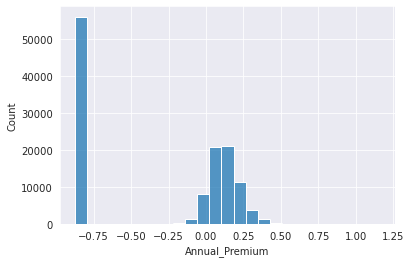

In [48]:
sns.histplot(data=X_resampled, x='Annual_Premium', bins=25)

In [49]:
pickle.dump(rbt_scaler, open('../deploy/mms_scaler.pkl', 'wb'))

# Modelos

Accuracy = 0.503
Precision = 0.879
Recall = 0.502
F1 score = 0.639
Balanced Accuracy = 0.504
Kappa Score = 0.00377


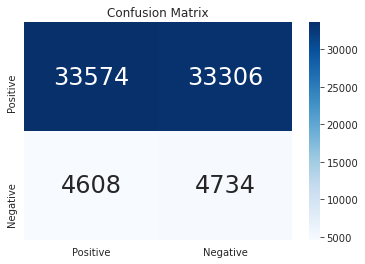

In [50]:
model = DummyClassifier()
model.fit(X_resampled, y_resampled)
pred = model.predict(X_test)
metric_score(model, y_test, pred)

Accuracy = 0.123
Precision = 0.0
Recall = 0.0
F1 score = 0.0
Balanced Accuracy = 0.5
Kappa Score = 0.0


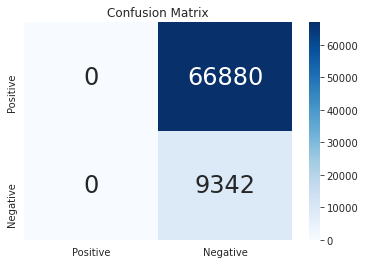

In [51]:
model = LogisticRegression()
model.fit(X_resampled, y_resampled)
pred = model.predict(X_test)
metric_score(model, y_test, pred)

Accuracy = 0.563
Precision = 0.999
Recall = 0.503
F1 score = 0.669
Balanced Accuracy = 0.749
Kappa Score = 0.197


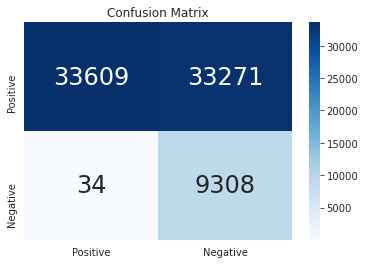

In [52]:
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)
pred = model.predict(X_test)
metric_score(model, y_test, pred)

Accuracy = 0.319
Precision = 0.998
Recall = 0.225
F1 score = 0.367
Balanced Accuracy = 0.611
Kappa Score = 0.0655


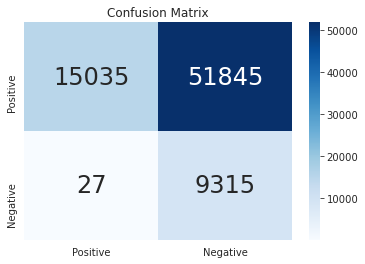

In [53]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)
pred = model.predict(X_test)
metric_score(model, y_test, pred)

Accuracy = 0.471
Precision = 0.999
Recall = 0.398
F1 score = 0.569
Balanced Accuracy = 0.698
Kappa Score = 0.139


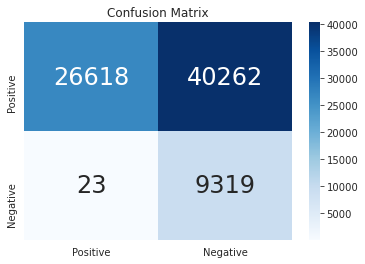

In [54]:
model = GradientBoostingClassifier()
model.fit(X_resampled, y_resampled)
pred = model.predict(X_test)
metric_score(model, y_test, pred)

[01:50:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.189
Precision = 0.999
Recall = 0.0753
F1 score = 0.14
Balanced Accuracy = 0.537
Kappa Score = 0.0195


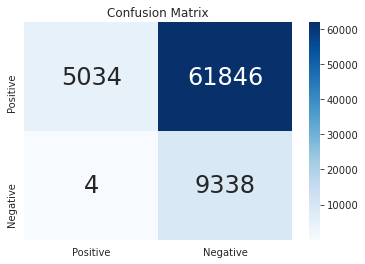

In [55]:
model = XGBClassifier()
model.fit(X_resampled, y_resampled)
pred = model.predict(X_test)
metric_score(model, y_test, pred)

# Validação

In [56]:
# X_test['Annual_Premium'] = np.log1p(X_test[['Annual_Premium']])
# X_test['Annual_Premium'] = rbt_scaler.transform( X_test[['Annual_Premium']].values )

## 5.1. Dummy Classifier

In [57]:
model_DM = DummyClassifier()
score_DM = score_ml('Dummy', model_DM)
score_DM

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5

Avg Balanced Accuracy: 0.4995 +/- 0.00272
Avg Kappa: -0.001028 +/- 0.00544


## 5.2. Logistic Regression

In [58]:
model_LR = LogisticRegression()
score_LR = score_ml('Regression', model_LR)
score_LR

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5

Avg Balanced Accuracy: 0.8419 +/- 0.0007551
Avg Kappa: 0.6839 +/- 0.00151


## 5.3. Random Forest Classifier

In [59]:
model_RF = RandomForestClassifier()
score_RF = score_ml('Random_Forest', model_RF)
score_RF

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5

Avg Balanced Accuracy: 0.851 +/- 0.001399
Avg Kappa: 0.702 +/- 0.002798


## 5.4. Decision Tree

In [60]:
model_DT = DecisionTreeClassifier()
score_DT = score_ml('Decision_Tree', model_DT)
score_DT

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5

Avg Balanced Accuracy: 0.8056 +/- 0.001321
Avg Kappa: 0.6112 +/- 0.002642


## 5.5. Gradient Boosting

In [61]:
model_GB = GradientBoostingClassifier()
score_GB = score_ml('Gradient Boost', model_GB)
score_GB

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5

Avg Balanced Accuracy: 0.8487 +/- 0.0009659
Avg Kappa: 0.6973 +/- 0.001932


## 5.6. XGBoost Classifier

In [62]:
model_XGB = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
score_XGB = score_ml('XGBoost', model_XGB)
score_XGB

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5

Avg Balanced Accuracy: 0.8539 +/- 0.0008126
Avg Kappa: 0.7077 +/- 0.001625


# 7.0. Hiperparâmetros

In [ ]:
modelo = RandomForestClassifier()

parameters = {'criterion': ["gini", "entropy"],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5, 10],
              'max_depth': [1, 5, 10]}

In [ ]:
clf = GridSearchCV(modelo, param_grid=parameters,
                   scoring='balanced_accuracy',
                   cv=10, n_jobs=2, verbose=1,)

In [ ]:
clf.fit(X_resampled, y_resampled)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

# 8.0. Testando Modelo

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


In [141]:
X_train['Annual_Premium'] = np.log1p(X_train[['Annual_Premium']])
X_train['Annual_Premium'] = rbt_scaler.fit_transform( X_train[['Annual_Premium']].values )

In [142]:
y_train.shape

(304887,)

In [143]:
print(y_train.shape)
print(y_train.value_counts(normalize=True))
undersampling = NearMiss(sampling_strategy=0.8)

X_train, y_train = undersampling.fit_sample(X_train, y_train)

print(y_train.shape)
print(y_train.value_counts())

# oversampling = SMOTE(sampling_strategy='minority')
# X_train, y_train = oversampling.fit_sample(X_train, y_train)

print(y_train.shape)
print(y_train.value_counts(normalize=True))

(304887,)
0    0.877437
1    0.122563
Name: Response, dtype: float64
(84078,)
0    46710
1    37368
Name: Response, dtype: int64
(84078,)
0    0.555556
1    0.444444
Name: Response, dtype: float64


In [144]:
y_train.value_counts()

0    46710
1    37368
Name: Response, dtype: int64

In [145]:
X1 = X_train.copy()
X1['Response'] = y_train

<AxesSubplot:xlabel='Annual_Premium', ylabel='Count'>

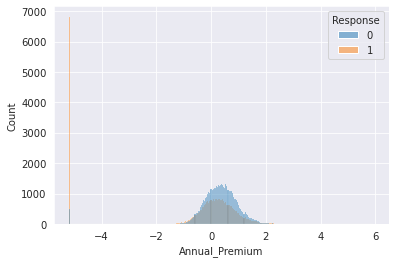

In [146]:
sns.histplot(data=X1, x='Annual_Premium', hue='Response')

In [147]:
clf_RF_tuned = RandomForestClassifier(criterion='entropy',
                                      max_depth=10,
                                      min_samples_leaf=5,
                                      min_impurity_split=2)
clf_RF_tuned.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_impurity_split=2,
                       min_samples_leaf=5)

In [148]:
X_test['Annual_Premium'] = np.log1p(X_test[['Annual_Premium']])
X_test['Annual_Premium'] = rbt_scaler.transform( X_test[['Annual_Premium']].values )

In [150]:
pred = clf_RF_tuned.predict(X_test)

Accuracy = 0.877
Precision = 0.877
Recall = 1.0
F1 score = 0.935
Balanced Accuracy = 0.5
Kappa Score = 0.0


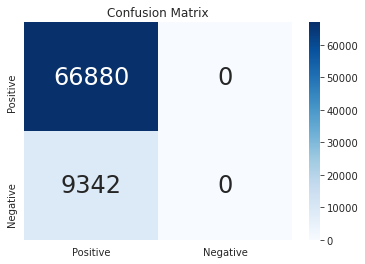

In [151]:
metric_score(clf_RF_tuned, y_test, pred)

# 9.0. - Modelo Final

In [ ]:
dataset_train = pd.read_csv('../data/preprocessed_train_data.csv', index_col='id')

X_df_train = dataset_train.drop(labels='Response', axis=1)
y_df_train = dataset_train['Response']

In [ ]:
y_df_test = pd.read_csv('../data/preprocessed_test_data.csv', index_col='id')

In [ ]:
modelo = GradientBoostingClassifier(learning_rate=0.1, max_depth=5,
                                    min_samples_split=3, n_estimators=150)
modelo.fit(X_df_train, y_df_train)

In [ ]:
previsoes = modelo.predict(y_df_test)

In [ ]:
df_prev = y_df_test.copy()
df_prev['Predict'] = previsoes

## 9.1. - Salvando o Modelo

In [ ]:
pickle.dump(modelo, open('../models/GB_tuned.pkl', 'wb'))

# 10.0. - Perguntas de Negócio

### 1. Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

Os algoritmos baseados em árvores rankeam as features mais relevantes para o modelo. Tendo isso em mente, utilizaremos este rankeamento para selecionar os atributos mais relevantes. 

In [ ]:
features_importantes = pd.DataFrame()
features_importantes['Features'] = y_df_test.columns

features_importantes['Importancia'] = modelo.feature_importances_
features_importantes.sort_values(by='Importancia', ascending=False)

### 2. Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [ ]:
df_random_20000 = df_prev.sample(n=20000, random_state=0)

In [ ]:
qnt_predicao_20000 = df_random_20000['Predict'].value_counts()
round((qnt_predicao_20000 / df_random_20000.shape[0]) * 100,2)

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df_random_20000, x='Predict')

### 3. E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [ ]:
df_random_40000 = df_prev.sample(n=40000, random_state=0)

In [ ]:
qnt_predicao_40000 = df_random_40000['Predict'].value_counts()
round((qnt_predicao_40000 / df_random_40000.shape[0]) * 100,2)

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df_random_40000, x='Predict')

### **4. Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?**

In [ ]:
count_predicoes = df_prev['Predict'].value_counts()
count_predicoes

In [ ]:
# num_ligacoes = round(count_predicoes * 0.8).astype('int').sum()
print(f'O time de vendas precisará fazer aproximadamente {num_ligacoes} ligações')